In [104]:
%autosave 20
%matplotlib inline
import os
import tarfile
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from six.moves import urllib
from IPython.core.interactiveshell import InteractiveShell
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.manifold import TSNE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import GridSearchCV


InteractiveShell.ast_node_interactivity = "all"

Autosaving every 20 seconds


## Import Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [88]:
fetch_housing_data()

## Initial Look

In [3]:
housing = load_housing_data()

housing.info()
housing.head()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff78320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11061e908>]], dtype=object)

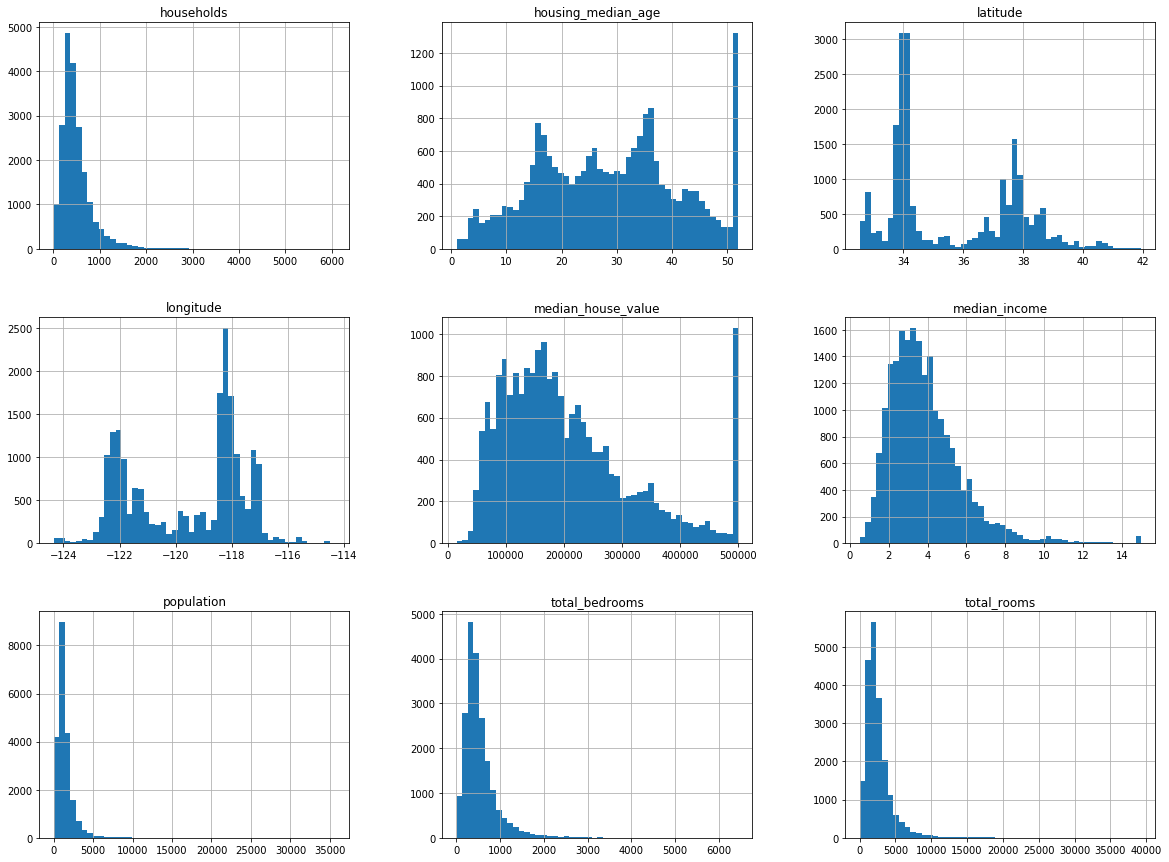

In [5]:
housing.hist(bins=50, figsize=(20, 15))

## Create a Test Set

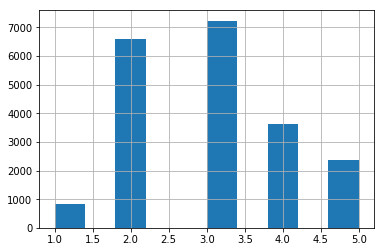

In [6]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

housing['income_cat'].hist()

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

## Explore Data

In [8]:
housing = strat_train_set.copy()

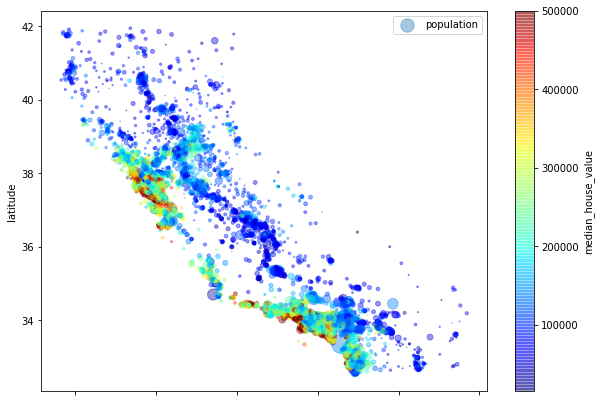

In [9]:
housing.plot(
    kind='scatter', x='longitude', y='latitude', alpha=0.4,
    s=housing['population']/100, label='population', figsize=(10,7),
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
)

In [10]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a2b6080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1b1358d0>]], dtype=object)

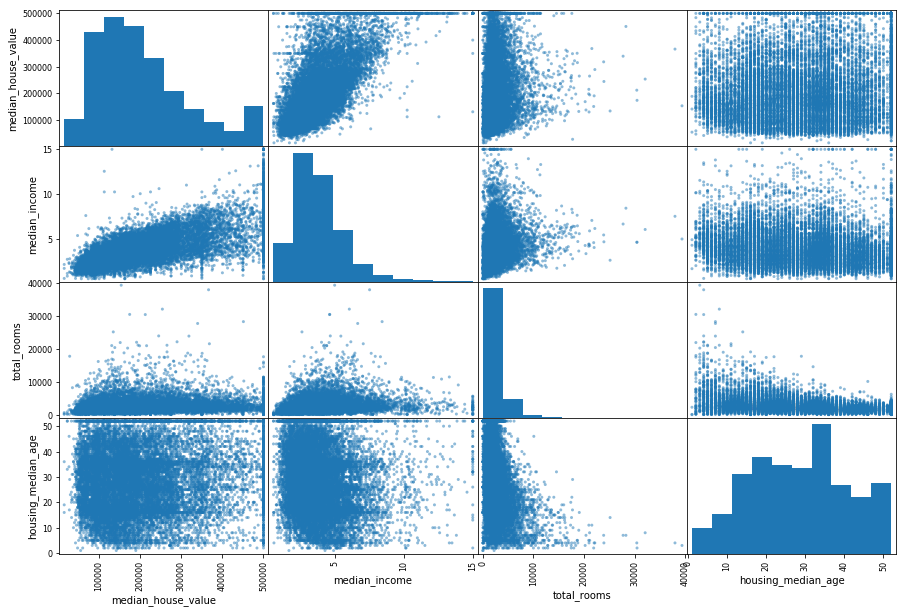

In [11]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(15, 10))

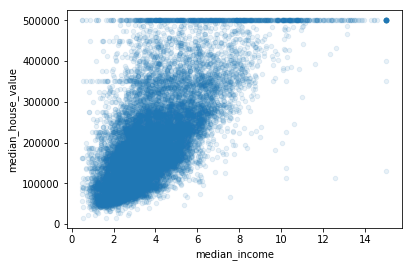

In [12]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

## Feature Engineering

In [13]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [14]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data Cleaning

In [15]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

housing.shape, housing_labels.shape

((16512, 9), (16512,))

In [16]:
# Filling missing values with the median of each attribute

imputer = Imputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

imputer.statistics_

housing_tr = pd.DataFrame(imputer.transform(housing_num), columns=housing_num.columns)
housing_tr.head()

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [17]:
housing_cat = housing['ocean_proximity']
housing_cat.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [43]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [46]:
# One-hot encode the 'ocean_proximity' categorical feature

housing_cat_encoded, housing_categories = housing_cat.factorize()

housing_cat_encoded[:10]
housing_categories

cat_encoder = CategoricalEncoder(encoding='onehot-dense')
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

housing_cat_1hot

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

## Transformation Pipeline

In [35]:
# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [36]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [38]:
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [39]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [49]:
num_attributes = list(housing_num)
cat_attributes = ['ocean_proximity']

num_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(cat_attributes)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [51]:
# T-SNE embedding for fun!

tsne = TSNE(n_components=2, random_state=42, verbose=2)
housing_prepared_2d = tsne.fit_transform(housing_prepared)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16512 samples in 0.019s...
[t-SNE] Computed neighbors for 16512 samples in 5.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16512
[t-SNE] Computed conditional probabilities for sample 2000 / 16512
[t-SNE] Computed conditional probabilities for sample 3000 / 16512
[t-SNE] Computed conditional probabilities for sample 4000 / 16512
[t-SNE] Computed conditional probabilities for sample 5000 / 16512
[t-SNE] Computed conditional probabilities for sample 6000 / 16512
[t-SNE] Computed conditional probabilities for sample 7000 / 16512
[t-SNE] Computed conditional probabilities for sample 8000 / 16512
[t-SNE] Computed conditional probabilities for sample 9000 / 16512
[t-SNE] Computed conditional probabilities for sample 10000 / 16512
[t-SNE] Computed conditional probabilities for sample 11000 / 16512
[t-SNE] Computed conditional probabilities for sample 12000 / 16512
[t-SNE] Computed conditional probabilities for sam

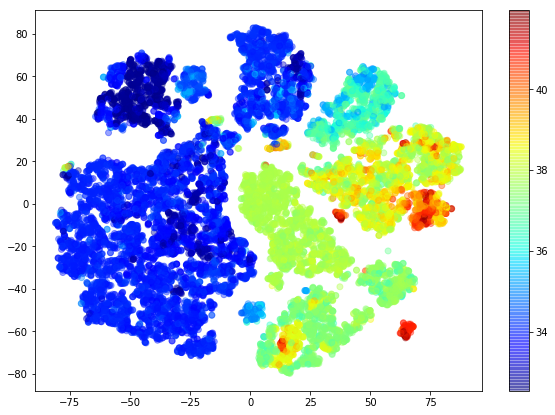

In [69]:
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    x=housing_prepared_2d[:, 0], y=housing_prepared_2d[:, 1], c=housing['latitude'], cmap=plt.get_cmap('jet'),
    alpha=0.4
)
plt.colorbar(sc)

## Selecting and Training Models

In [92]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

### Linear Regression

In [98]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

scores = cross_val_score(
    estimator=lin_reg, X=housing_prepared, y=housing_labels,
    scoring='neg_mean_squared_error', cv=10
)

lin_rmse_scores = np.sqrt(-scores)

print("rmse: ", lin_rmse)
display_scores(lin_rmse_scores)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

rmse:  68628.1981985
Scores:  [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean:  69052.4613635
Standard deviation:  2731.6740018


### Decision Tree Regressor

In [97]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

scores = cross_val_score(
    estimator=tree_reg, X=housing_prepared, y=housing_labels,
    scoring='neg_mean_squared_error', cv=10
)

tree_rmse_scores = np.sqrt(-scores)

print("rmse: ", tree_rmse)
display_scores(tree_rmse_scores)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

rmse:  0.0
Scores:  [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean:  71379.0744771
Standard deviation:  2458.31882043


### Random Forest Regressor

In [100]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

scores = cross_val_score(
    estimator=forest_reg, X=housing_prepared, y=housing_labels,
    scoring='neg_mean_squared_error', cv=10
)

forest_rmse_scores = np.sqrt(-scores)

print("rmse: ", forest_rmse)
display_scores(forest_rmse_scores)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

rmse:  21941.9110274
Scores:  [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean:  52564.1902524
Standard deviation:  2301.87380392


### Support Vector Machine

In [103]:
svm_reg = svm.SVR()
svm_reg.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

scores = cross_val_score(
    estimator=svm_reg, X=housing_prepared, y=housing_labels,
    scoring='neg_mean_squared_error', cv=10
)

svm_rmse_scores = np.sqrt(-scores)

print("rmse: ", svm_rmse)
display_scores(svm_rmse_scores)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

rmse:  118577.433564
Scores:  [ 111393.33263237  119546.71049753  116961.00489445  120449.0155974
  117622.20149716  122303.76986818  117640.09907103  121459.63518806
  120348.51364519  118025.61954959]
Mean:  118574.990244
Standard deviation:  2934.13294331


### Grid Search

In [106]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid, cv=5, 
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

{'max_features': 8, 'n_estimators': 30}

In [107]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63647.854446 {'max_features': 2, 'n_estimators': 3}
55611.5015988 {'max_features': 2, 'n_estimators': 10}
53370.0640736 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.4998083 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.8922859 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.3582936 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.0168279 {'bootstrap': False, 'max_features': 4, 'n_estima

In [108]:
feature_importance = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_household', 'pop_per_household', 'bedrooms_per_room']
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse=True)

[(0.36615898061813418, 'median_income'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'pop_per_household'),
 (0.073344235516012421, 'longitude'),
 (0.062909070482620302, 'latitude'),
 (0.056419179181954007, 'rooms_per_household'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

## Evalute Model on Test Set

In [109]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

inal